In [2]:
import tensorflow as tf
import numpy as np

2024-11-23 18:51:19.518337: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732384279.540430   39457 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732384279.547026   39457 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-23 18:51:19.568498: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Dividir en train val y test

In [3]:
import splitfolders

input_folder = "../Celebrity_Faces_Dataset_Duplicada"
output_folder = "../Celebrity_Faces_Dataset_Duplicada_SPLITTED"

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.7, 0.2, 0.1))

Copying files: 1711 files [00:00, 3444.43 files/s]


### Cargar la informacion en train_data, val_data y test_data

In [4]:
TAM_IMG = 200
BATCH_SIZE_LOADER = 32
COLOR_MODE = 'rgb'

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,          # Escalado de píxeles al rango [0, 1]
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [6]:
# Directorios
train_dir = "../Celebrity_Faces_Dataset_Duplicada_SPLITTED/train"
val_dir = "../Celebrity_Faces_Dataset_Duplicada_SPLITTED/val"

COLOR_MODE = 'rgb'
# Crear generadores de datos
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(TAM_IMG, TAM_IMG),
    batch_size=BATCH_SIZE_LOADER,
    color_mode=COLOR_MODE,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(TAM_IMG, TAM_IMG),
    batch_size=BATCH_SIZE_LOADER,
    color_mode=COLOR_MODE,
    class_mode='categorical'
)


Found 1197 images belonging to 17 classes.
Found 341 images belonging to 17 classes.


### Crear modelo, entrenarlo y testearlo con estructura básica

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l2

#### "Diseñar modelo"

In [8]:
input_shape = (TAM_IMG, TAM_IMG, 3)
neuronas_salida = len(train_data.class_indices)
filtros_conv = 32
neuronas_capa_densa = 64
kernel_size = (5, 5)
padding_tipo = 'valid'


model_1 = Sequential([
    Input(shape=input_shape),
    Conv2D(filtros_conv, kernel_size, activation='relu', padding=padding_tipo),
    MaxPooling2D((2, 2)),
    Conv2D(filtros_conv*2, kernel_size, activation='relu', padding=padding_tipo),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(neuronas_capa_densa, activation='relu'),
    Dropout(0.5),
    Dense(neuronas_salida, activation='softmax')
])

model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_1.summary()

I0000 00:00:1732384285.635038   39457 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2246 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 196, 196, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 98, 98, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 94, 94, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 47, 47, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 141376)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     9,048,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 17)             │         1,105 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,102,929 (34.72 MB)

 Trainable params: 9,102,929 (34.72 MB)

 Non-trainable params: 0 (0.00 B)

#### Entrenar modelo

In [9]:
model_1.fit(train_data, validation_data=val_data, epochs=20, batch_size=16)

/home/david/miniconda3/envs/tf_wsl/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1732384306.001968   41791 service.cc:148] XLA service 0x7f4a9000afe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732384306.002410   41791 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-11-23 18:51:46.038369: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732384306.257118   41791 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-23 18:51:48.530498: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,32,196,196]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,200,200]{3,2,1,0}, f32[32,3,5,5]{3,2,1,0}, f32[32]{0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"act

13/38 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.0623 - loss: 3.6735

2024-11-23 18:52:16.197465: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng20{k2=2,k4=2,k5=0,k6=0,k7=0,k19=0} for conv (f32[13,32,196,196]{3,2,1,0}, u8[0]{0}) custom-call(f32[13,3,200,200]{3,2,1,0}, f32[32,3,5,5]{3,2,1,0}, f32[32]{0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2024-11-23 18:52:16.878574: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.681180483s
Trying algorithm eng20{k2=2,k4=2,k5=0,k6=0,k7=0,k19=0} for conv (f32[13,32,196,196]{3,2,1,0}, u8[0]{0}) custom-call(f32[13,3,200,200]{3,2,1,0}, f32[32,3,5,5]{3,2,1,0}, f32[32]{0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convB

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.0609 - loss: 3.2705

2024-11-23 18:52:26.287635: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,32,196,196]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,200,200]{3,2,1,0}, f32[32,3,5,5]{3,2,1,0}, f32[32]{0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-11-23 18:52:26.653970: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,64,94,94]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,98,98]{3,2,1,0}, f32[64,32,5,5]{3,2,1,0}, f32[64]{0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_con

38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 497ms/step - accuracy: 0.0609 - loss: 3.2629 - val_accuracy: 0.0499 - val_loss: 2.8274
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.0639 - loss: 2.8238 - val_accuracy: 0.0704 - val_loss: 2.8179
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.1358 - loss: 2.7563 - val_accuracy: 0.1261 - val_loss: 2.7340
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.1896 - loss: 2.5266 - val_accuracy: 0.1408 - val_loss: 2.6771
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.3198 - loss: 2.1004 - val_accuracy: 0.1584 - val_loss: 2.6905
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.5007 - loss: 1.5731 - val_accuracy: 0.1496 - val_loss: 2.8484
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.6162 - loss: 1.1531 - val_accuracy: 0.1877 - val_loss: 3.0558
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.7235 - loss: 0.8766 - val_accuracy: 0.1877 - val_loss: 

In [10]:
# Overfitting de manual

#### Evaluar modelo

Acuraccy

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

Esto lo he hecho porque me daba 2 resultados diferentes dependiendo de con que se calcula la accuracy si no cargaba los datos de test justo antes de hacer la prueba

In [12]:
datagen = ImageDataGenerator(rescale=1.0/255.0)

test_dir = "../Celebrity_Faces_Dataset_Duplicada_SPLITTED/test"

test_data = datagen.flow_from_directory(
    test_dir,
    target_size=(TAM_IMG, TAM_IMG),
    batch_size=BATCH_SIZE_LOADER,
    class_mode='categorical',
    shuffle=False
)

y_pred = model_1.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_data.classes

acc = accuracy_score(y_true, y_pred_classes)
test_loss, test_acc = model_1.evaluate(test_data)

print(f"Accuracy sklearn (accuracy_score): {acc:.4f}")
print(f"Test Accuracy Keras (model.evaluate): {test_acc:.4f}")

Found 173 images belonging to 17 classes.


/home/david/miniconda3/envs/tf_wsl/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

2024-11-23 18:53:38.418673: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[13,32,196,196]{3,2,1,0}, u8[0]{0}) custom-call(f32[13,3,200,200]{3,2,1,0}, f32[32,3,5,5]{3,2,1,0}, f32[32]{0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-11-23 18:53:38.576413: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[13,64,94,94]{3,2,1,0}, u8[0]{0}) custom-call(f32[13,32,98,98]{3,2,1,0}, f32[64,32,5,5]{3,2,1,0}, f32[64]{0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_con

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 684ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.1386 - loss: 4.4747
Accuracy sklearn (accuracy_score): 0.1676
Test Accuracy Keras (model.evaluate): 0.1676


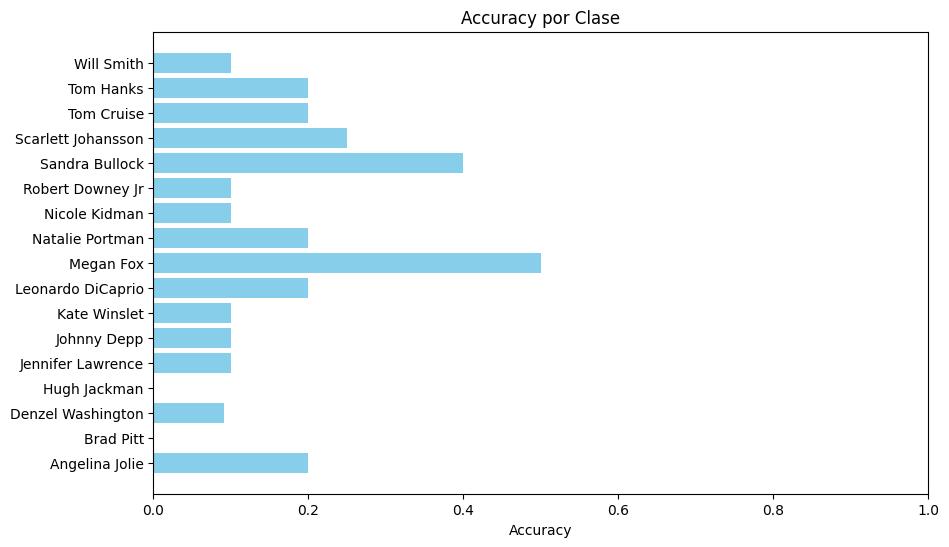

In [13]:
from sklearn.metrics import accuracy_score
import numpy as np

class_labels = list(test_data.class_indices.keys())
accuracy_scores = []

for i, label in enumerate(class_labels):
    class_indices = np.where(y_true == i)[0]
    class_accuracy = accuracy_score(y_true[class_indices], y_pred_classes[class_indices])
    accuracy_scores.append(class_accuracy)

# Crear la gráfica de barras para la Accuracy por clase
plt.figure(figsize=(10, 6))
plt.barh(class_labels, accuracy_scores, color='skyblue')
plt.xlabel('Accuracy')
plt.title('Accuracy por Clase')
plt.xlim(0, 1)
plt.show()

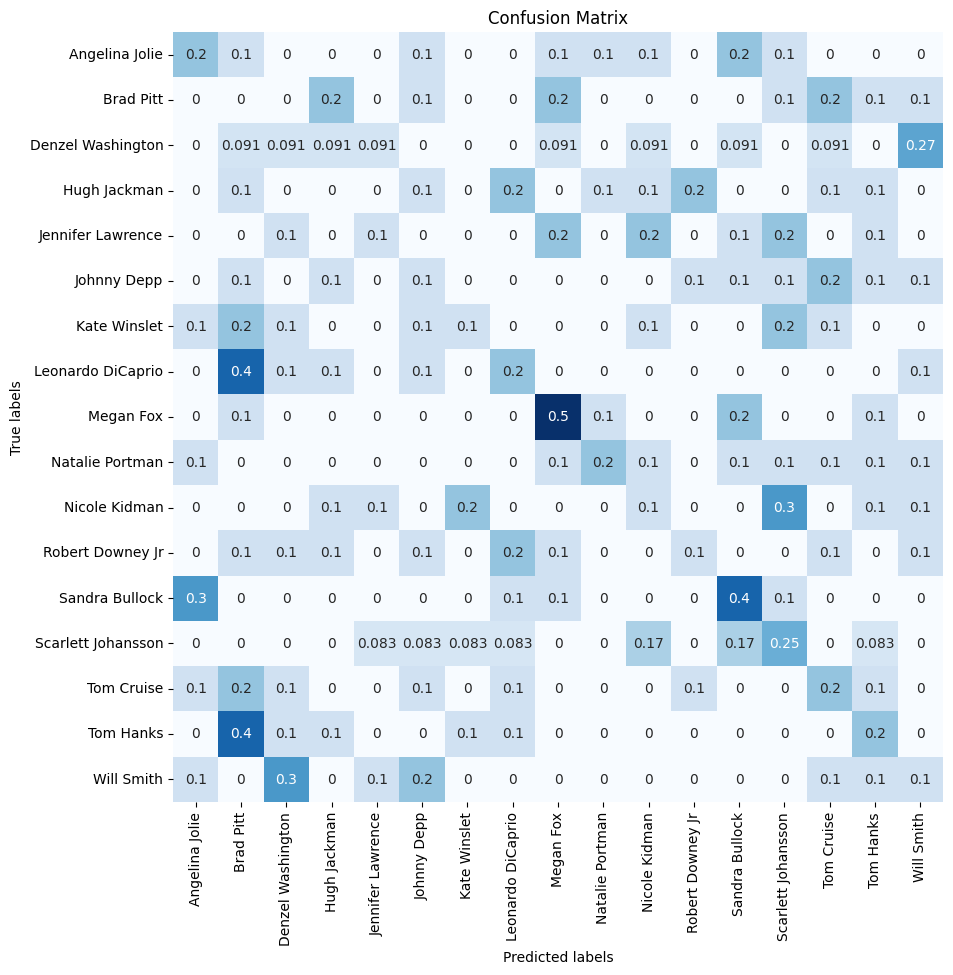

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)

# Normalizar la matriz de confusión
cm = cm / cm.sum(axis=1)[:, np.newaxis]

# Crear la figura
plt.figure(figsize=(10, 10))

# Graficar la matriz de confusión
sns.heatmap(cm, annot=True, square=True, cmap='Blues', cbar=False, xticklabels=test_data.class_indices, yticklabels=test_data.class_indices)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


F1-Score

{'Angelina Jolie': {'precision': 0.2222222222222222, 'recall': 0.2, 'f1-score': 0.21052631578947367, 'support': 10.0}, 'Brad Pitt': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10.0}, 'Denzel Washington': {'precision': 0.1, 'recall': 0.09090909090909091, 'f1-score': 0.09523809523809523, 'support': 11.0}, 'Hugh Jackman': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10.0}, 'Jennifer Lawrence': {'precision': 0.2, 'recall': 0.1, 'f1-score': 0.13333333333333333, 'support': 10.0}, 'Johnny Depp': {'precision': 0.09090909090909091, 'recall': 0.1, 'f1-score': 0.09523809523809523, 'support': 10.0}, 'Kate Winslet': {'precision': 0.2, 'recall': 0.1, 'f1-score': 0.13333333333333333, 'support': 10.0}, 'Leonardo DiCaprio': {'precision': 0.2, 'recall': 0.2, 'f1-score': 0.2, 'support': 10.0}, 'Megan Fox': {'precision': 0.35714285714285715, 'recall': 0.5, 'f1-score': 0.4166666666666667, 'support': 10.0}, 'Natalie Portman': {'precision': 0.4, 'recall': 0.2, 'f1-score': 0

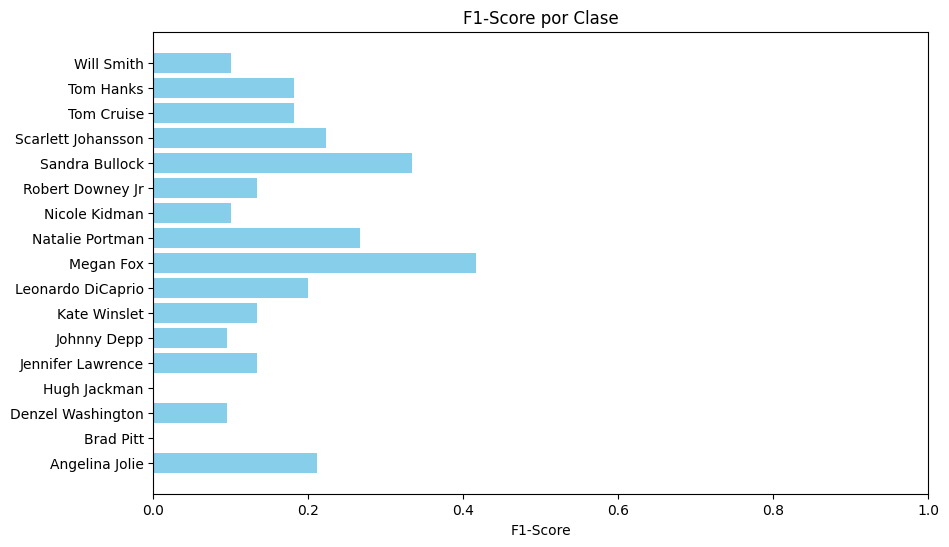

In [15]:
from sklearn.metrics import classification_report

class_labels = list(test_data.class_indices.keys())

# Extraer las métricas del reporte de clasificación
report_dict = classification_report(y_true, y_pred_classes, target_names=class_labels, output_dict=True)
print(report_dict)

f1_scores = [report_dict[label]['f1-score'] for label in class_labels]

plt.figure(figsize=(10, 6))
plt.barh(class_labels, f1_scores, color='skyblue')
plt.xlabel('F1-Score')
plt.title('F1-Score por Clase')
plt.xlim(0, 1)
plt.show()

#### Ejemplo imagenes mal clasificadas


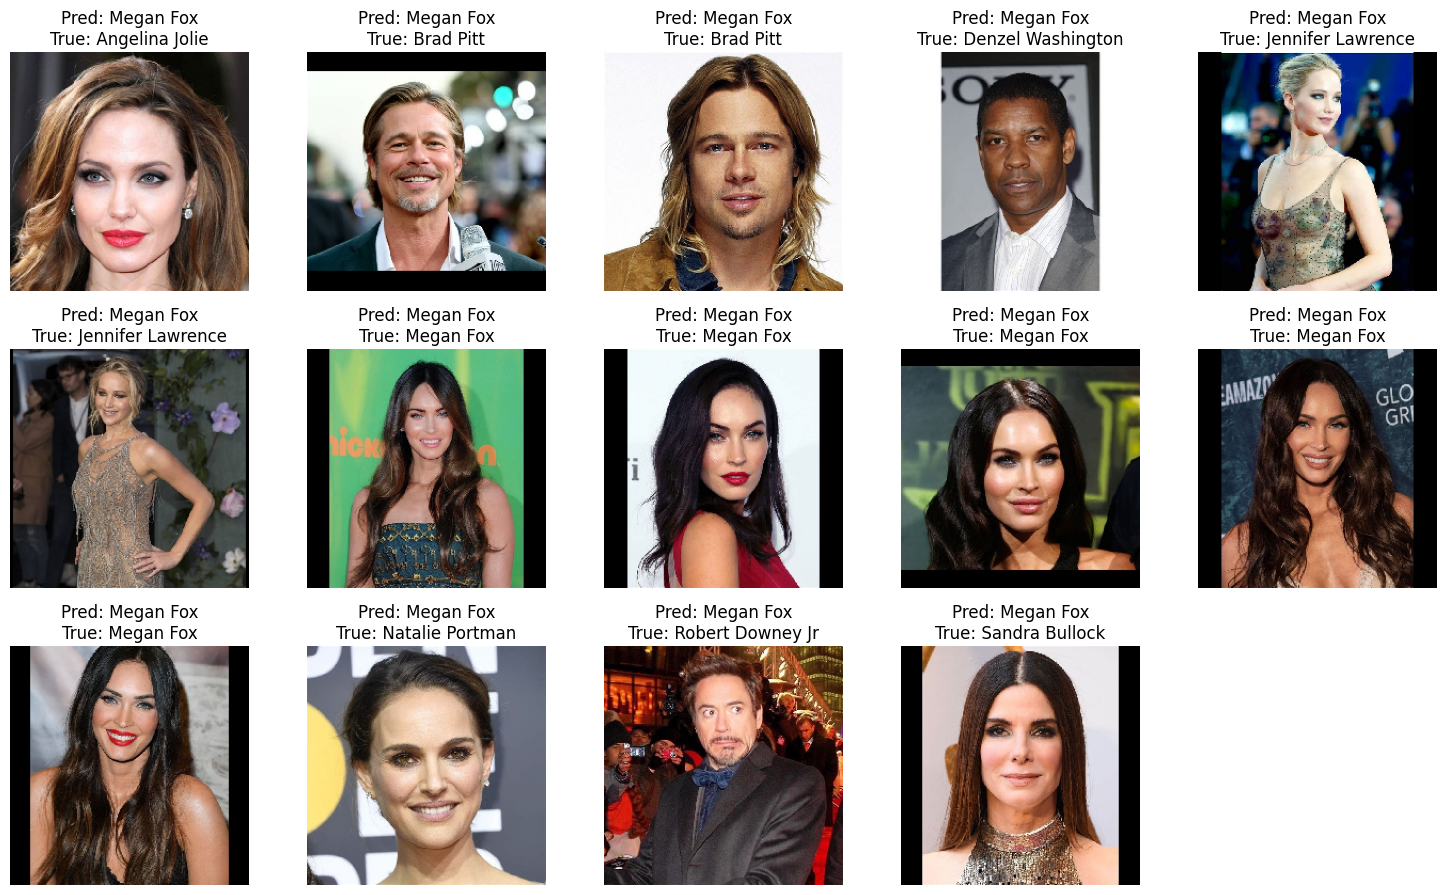

In [16]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Ruta del directorio de prueba
test_dir = '../Celebrity_Faces_Dataset_Duplicada_SPLITTED/test'

celebrity_name = 'Megan Fox'

# Etiqueta de Natalie Portman
natalie_portman_label = test_data.class_indices[celebrity_name]

# Identificar las imágenes clasificadas como Natalie Portman
classified_indices = np.where(y_pred_classes == natalie_portman_label)[0]

# Mostrar las imágenes clasificadas como Natalie Portman
num_images = len(classified_indices)
plt.figure(figsize=(15, 15))
for i, idx in enumerate(classified_indices):
    # Obtener el nombre del archivo de la imagen
    img_path = os.path.join(test_dir, test_data.filenames[idx])
    # Cargar la imagen
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    
    plt.subplot(5, 5, i + 1)  # Ajusta el tamaño de la cuadrícula según sea necesario
    plt.imshow(img_array.astype('uint8'))
    plt.title(f'Pred: {celebrity_name}\nTrue: {class_labels[y_true[idx]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

Esto es una prueba con una red convolucional sencilla, en el siguiente cuaderno la mejoraremos

In [17]:
# guardar el modelo acc 0.1676
model_1.save('../modelos/modelo_1-1_Basico_acc_0-17.keras')


2024-11-23 18:54:06.727296: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 36192256 exceeds 10% of free system memory.
2024-11-23 18:54:06.886898: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 36192256 exceeds 10% of free system memory.
2024-11-23 18:54:07.742218: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 36192256 exceeds 10% of free system memory.
